## Introduction

The purpose of this notebook is to analyze long-term trends (warming ocean temperatures, more frequent or intense storms, etc) of seven major ocean basins: the Arctic, North Atlantic, South Atlantic, Indian, North Pacific, South Pacific, and Southern Oceans by utilizing 80 years of data comprising of daily sea surface temperature, wave height, and wind speed.

This notebook utilizes data queried from the ERA5 Reanalysis Product produced by the European Center for Medium-Range Weather Forecasting (ECMWF), widely regarded as the best forecasting center in the world.

## Import Libraries

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

## Load Data

In [2]:
arctic = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/arctic.csv')
indian = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/indian.csv')
north_atlantic = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/north_atlantic.csv')
north_pacific = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/north_pacific.csv')
south_atlantic = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/south_atlantic.csv')
south_pacific = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/south_pacific.csv')
southern_seas = pd.read_csv('https://raw.githubusercontent.com/kikayjane/Climate/main/data/southern_seas.csv')

In [10]:
arctic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30747 entries, 0 to 30746
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   temperature  30747 non-null  float64       
 1   speed        30747 non-null  float64       
 2   height       6123 non-null   float64       
 3   date         30747 non-null  datetime64[ns]
 4   latitude     30747 non-null  int64         
 5   longitude    30747 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.4 MB


In [11]:
arctic.head()

,temperature,speed,height,date,latitude,longitude
0,271.45996,0.009604,NaN,2040-01-01 12:00:00,70,-140.1
1,271.45996,6.529120,NaN,2040-01-02 12:00:00,70,-140.1
2,271.45996,5.675279,NaN,2040-01-03 12:00:00,70,-140.1
3,271.45996,-10.479511,NaN,2040-01-04 12:00:00,70,-140.1
4,271.45996,-14.644253,NaN,2040-01-05 12:00:00,70,-140.1


## State your questions



*   What is the expected trend in sea surface temperature in the North Atlantic over the next 10 years?
*   Are there any predicted increases or decreases in the sea surface temperature over the forecast period?



## Analysis

<ipython-input-3-6f4b93e864a4>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
<ipython-input-3-6f4b93e864a4>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
<ipython-input-3-6f4b93e864a4>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')
<ipython-input-3-6f4b93e864a4>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `da

1974-01-01 12:00:00 2073-12-31 12:00:00


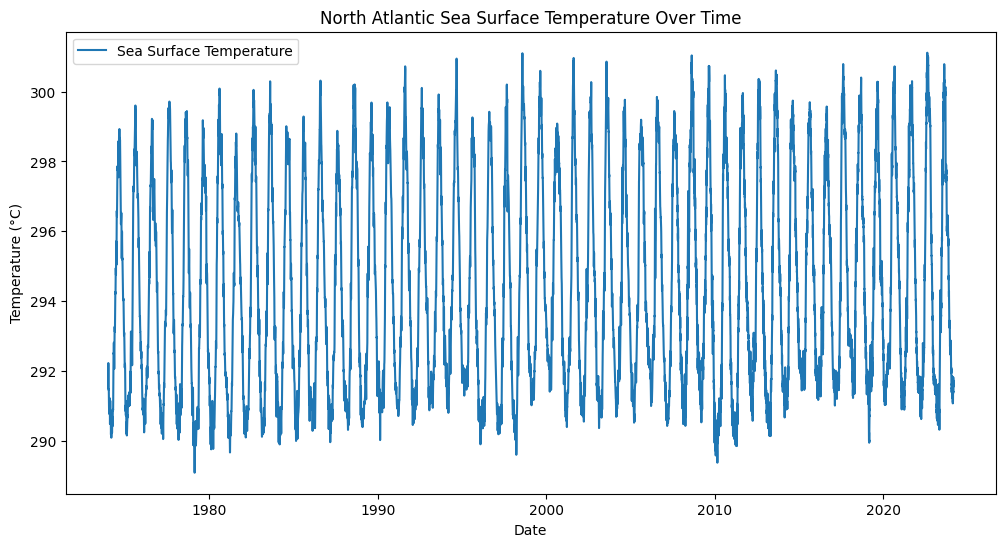

In [3]:
# Dictionary for renaming columns
rename_dict = {"sst": "temperature", "u10": "speed", "hsig": "height", "time": "date"}

# List of datasets
datasets = [arctic, indian, north_atlantic, north_pacific, south_atlantic, south_pacific, southern_seas]

# Rename columns for all datasets
for dataset in datasets:
    dataset.rename(columns=rename_dict, inplace=True)

# Convert date columns to datetime
for dataset in datasets:
    dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')

# Drop rows with parsing errors
for dataset in datasets:
    dataset.dropna(subset=['date'], inplace=True)

# Set date as index for North Atlantic dataset
north_atlantic.set_index('date', inplace=True)

# Check the date range
print(north_atlantic.index.min(), north_atlantic.index.max())

# Filter out any future dates beyond the current date
current_date = pd.Timestamp.now()
north_atlantic = north_atlantic[north_atlantic.index <= current_date]

# Plot the sea surface temperature
plt.figure(figsize=(12, 6))
plt.plot(north_atlantic['temperature'], label='Sea Surface Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('North Atlantic Sea Surface Temperature Over Time')
plt.legend()
plt.show()

<ipython-input-4-06f10004fae7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_atlantic['temp_lagged'] = north_atlantic['temperature'].shift(k)
<ipython-input-4-06f10004fae7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_atlantic.dropna(inplace=True)


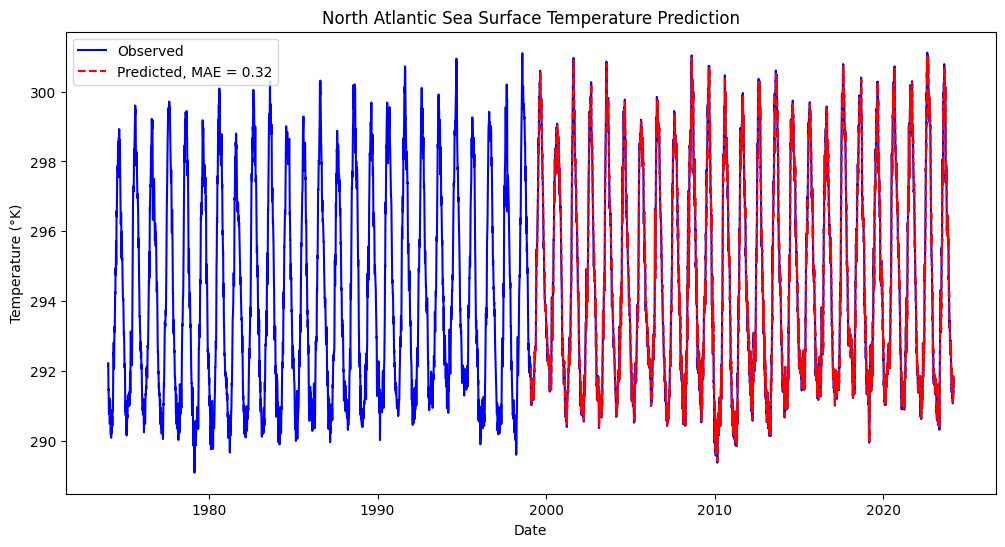

In [4]:
import numpy as np

# Create lagged features
k = 4  # Lag of 4 for example
north_atlantic['temp_lagged'] = north_atlantic['temperature'].shift(k)

# Drop NaN values created by lagging
north_atlantic.dropna(inplace=True)

# Split data into train and test sets
train_size = len(north_atlantic) // 2
train = north_atlantic.iloc[:train_size]
test = north_atlantic.iloc[train_size:]

# Train-test split for lagged data
X_train = train[['temp_lagged']]
y_train = train['temperature']
X_test = test[['temp_lagged']]
y_test = test['temperature']

# Train the linear regression model
reg = LinearRegression().fit(X_train, y_train)

# Make predictions
y_pred = reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_pred - y_test))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(north_atlantic.index, north_atlantic['temperature'], label='Observed', color='blue')
plt.plot(test.index, y_pred, label=f'Predicted, MAE = {mae:.2f}', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (°K)')
plt.title('North Atlantic Sea Surface Temperature Prediction')
plt.legend()
plt.show()

<ipython-input-12-6e3b41106369>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_atlantic['trend'] = result.trend
<ipython-input-12-6e3b41106369>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_atlantic['seasonal'] = result.seasonal
<ipython-input-12-6e3b41106369>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

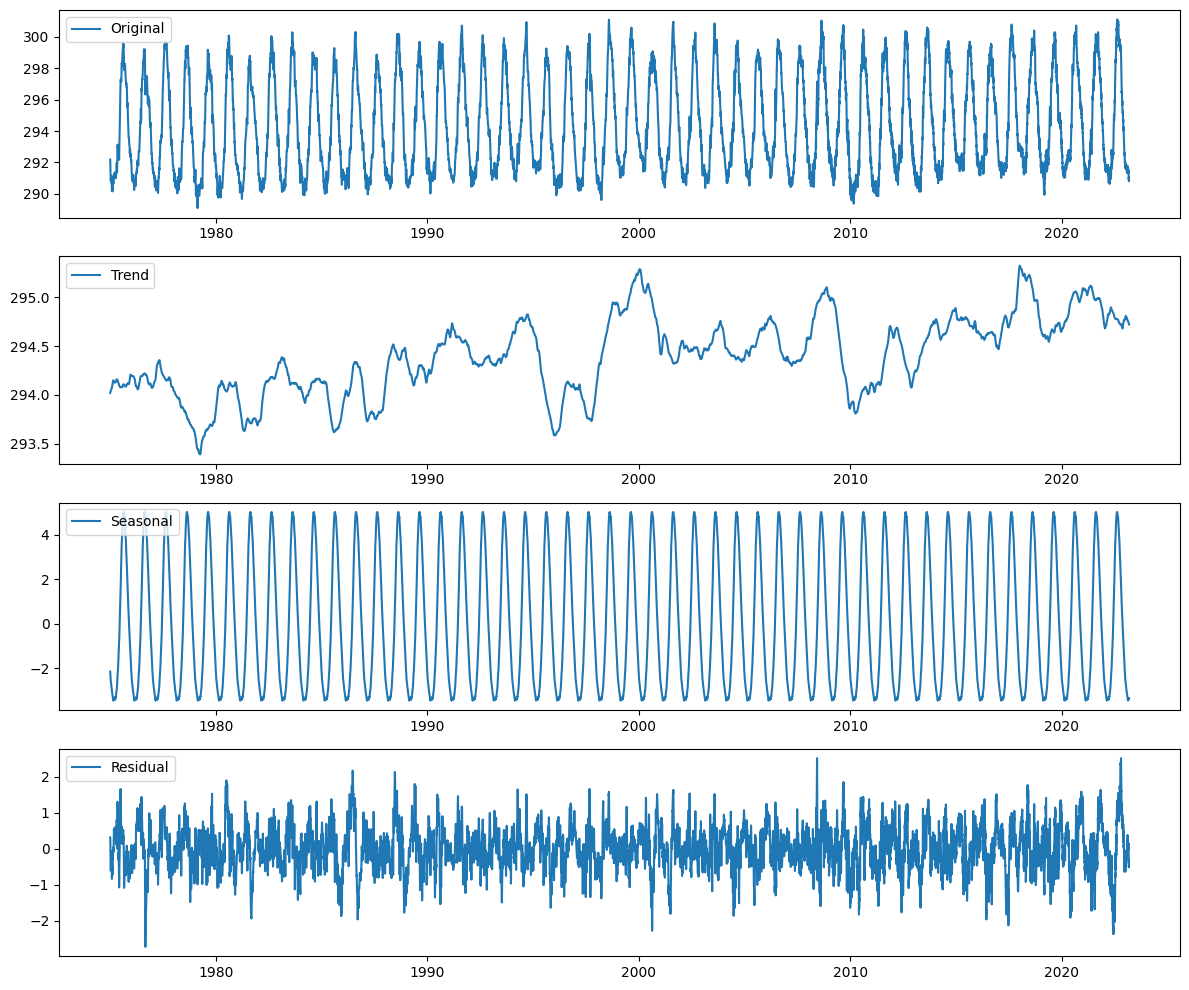

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


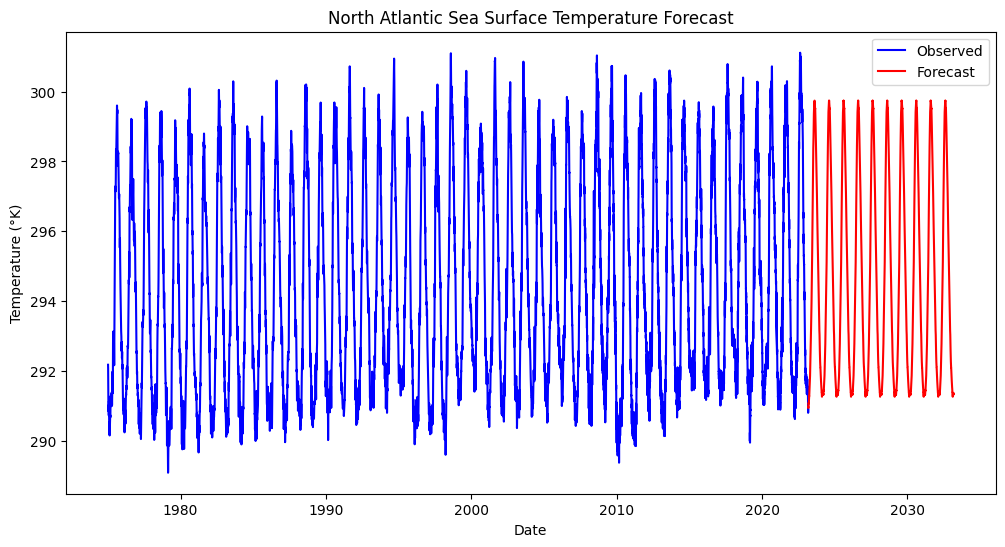

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
# Decompose the time series
result = seasonal_decompose(north_atlantic['temperature'], model='additive', period=365)
north_atlantic['trend'] = result.trend
north_atlantic['seasonal'] = result.seasonal
north_atlantic['residual'] = result.resid

# Drop NaN values created by decomposition
north_atlantic.dropna(inplace=True)

# Plot the decomposition results
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(north_atlantic['temperature'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(north_atlantic['trend'], label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(north_atlantic['seasonal'], label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(north_atlantic['residual'], label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Fit AR model to the residual component
lags = 30  # Number of lags
ar_model = AutoReg(north_atlantic['residual'], lags=lags).fit()

# Forecast future residuals
forecast_steps = 365 * 10  # Forecasting for 10 years
forecast_residuals = ar_model.predict(start=len(north_atlantic), end=len(north_atlantic) + forecast_steps - 1, dynamic=False)
forecast_index = pd.date_range(start=north_atlantic.index[-1], periods=forecast_steps, freq='D')

# Combine forecast with trend and seasonal components
last_trend = north_atlantic['trend'].iloc[-1]
last_seasonal = north_atlantic['seasonal'].iloc[-365:]
forecast_trend = np.linspace(last_trend, last_trend, forecast_steps)
forecast_seasonal = np.tile(last_seasonal, int(np.ceil(forecast_steps / 365)))[:forecast_steps]
forecast = forecast_residuals + forecast_trend + forecast_seasonal

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(north_atlantic.index, north_atlantic['temperature'], label='Observed', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (°K)')
plt.title('North Atlantic Sea Surface Temperature Forecast')
plt.legend()
plt.show()

<ipython-input-6-871d03501980>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['trend'] = result.trend
<ipython-input-6-871d03501980>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['seasonal'] = result.seasonal
<ipython-input-6-871d03501980>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Mean Squared Error: 34.293022399522954


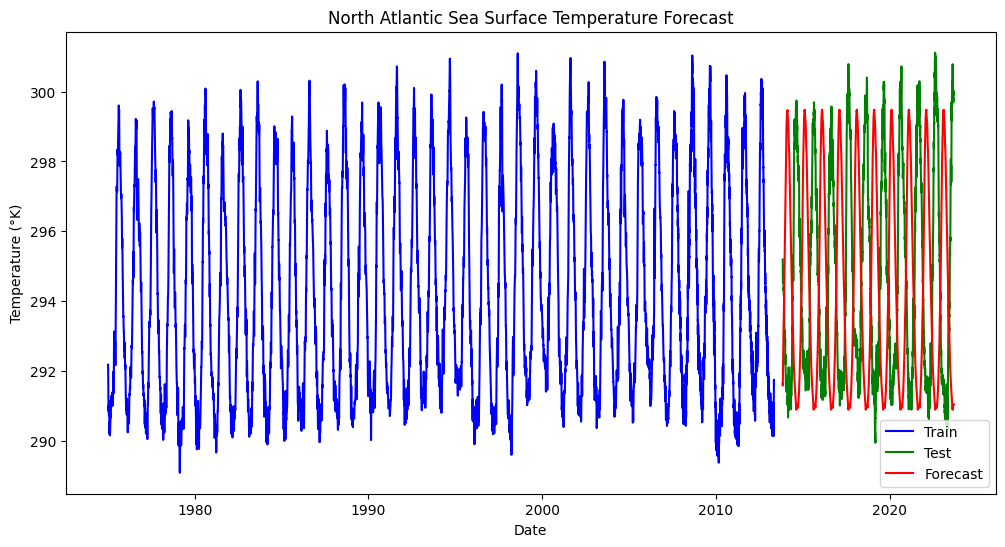

In [6]:
train_size = int(len(north_atlantic) * 0.8)
train, test = north_atlantic.iloc[:train_size], north_atlantic.iloc[train_size:]

# Decompose the training time series
result = seasonal_decompose(train['temperature'], model='additive', period=365)
train['trend'] = result.trend
train['seasonal'] = result.seasonal
train['residual'] = result.resid

# Drop NaN values created by decomposition
train.dropna(inplace=True)

# Fit AR model to the residual component
lags = 30  # Number of lags
ar_model = AutoReg(train['residual'], lags=lags).fit()

# Forecast future residuals
forecast_steps = len(test)  # Forecasting the length of the test set
forecast_residuals = ar_model.predict(start=len(train), end=len(train) + forecast_steps - 1, dynamic=False)
forecast_index = test.index

# Combine forecast with trend and seasonal components
last_trend = train['trend'].iloc[-1]
last_seasonal = train['seasonal'].iloc[-365:]
forecast_trend = np.linspace(last_trend, last_trend, forecast_steps)
forecast_seasonal = np.tile(last_seasonal, int(np.ceil(forecast_steps / 365)))[:forecast_steps]
forecast = forecast_residuals + forecast_trend + forecast_seasonal

# Calculate MSE
mse = mean_squared_error(test['temperature'], forecast)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['temperature'], label='Train', color='blue')
plt.plot(test.index, test['temperature'], label='Test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (°K)')
plt.title('North Atlantic Sea Surface Temperature Forecast')
plt.legend()
plt.show()

## Additional Step/Question



*   How does sea surface temperature correlate with wind speed and wave height over time in the North Atlantic?
*   Do the relationships between the variables change with seasons?





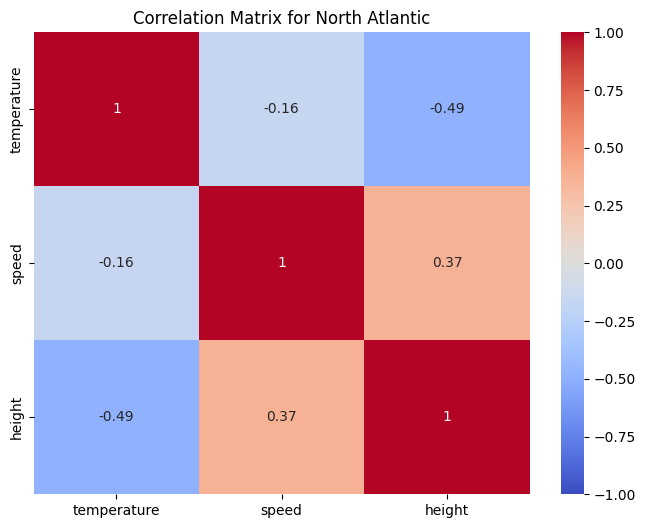

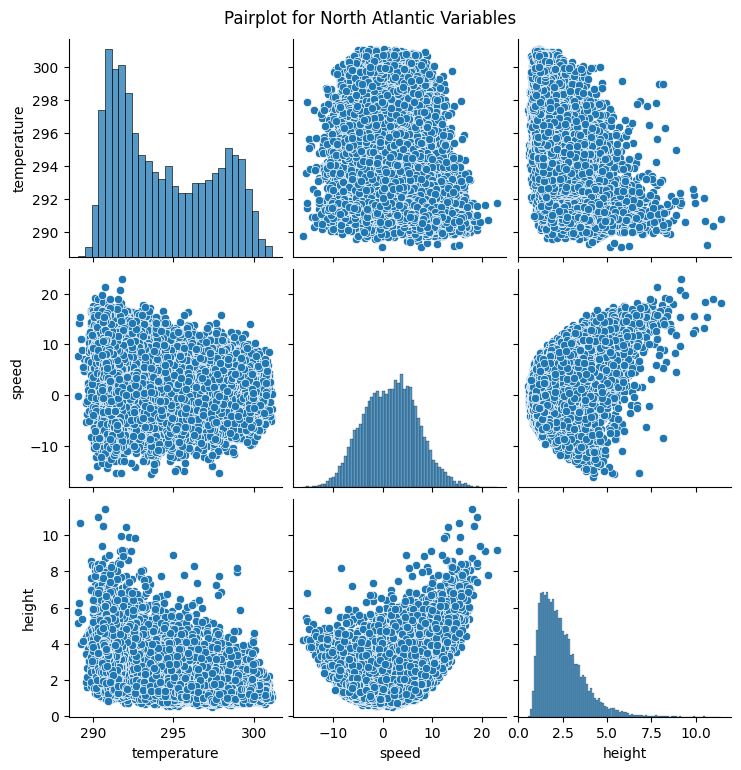

Correlation Matrix:
             temperature     speed    height
temperature     1.000000 -0.160428 -0.490082
speed          -0.160428  1.000000  0.374405
height         -0.490082  0.374405  1.000000


In [7]:
import seaborn as sns
# Calculate correlation matrix
correlation_matrix = north_atlantic[['temperature', 'speed', 'height']].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for North Atlantic')
plt.show()

# Plot pairplot to visualize relationships
sns.pairplot(north_atlantic[['temperature', 'speed', 'height']])
plt.suptitle('Pairplot for North Atlantic Variables', y=1.02)
plt.show()

# Interpret the results
print("Correlation Matrix:")
print(correlation_matrix)

<ipython-input-8-d510092fc409>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  north_atlantic['season'] = north_atlantic.index.map(assign_season)


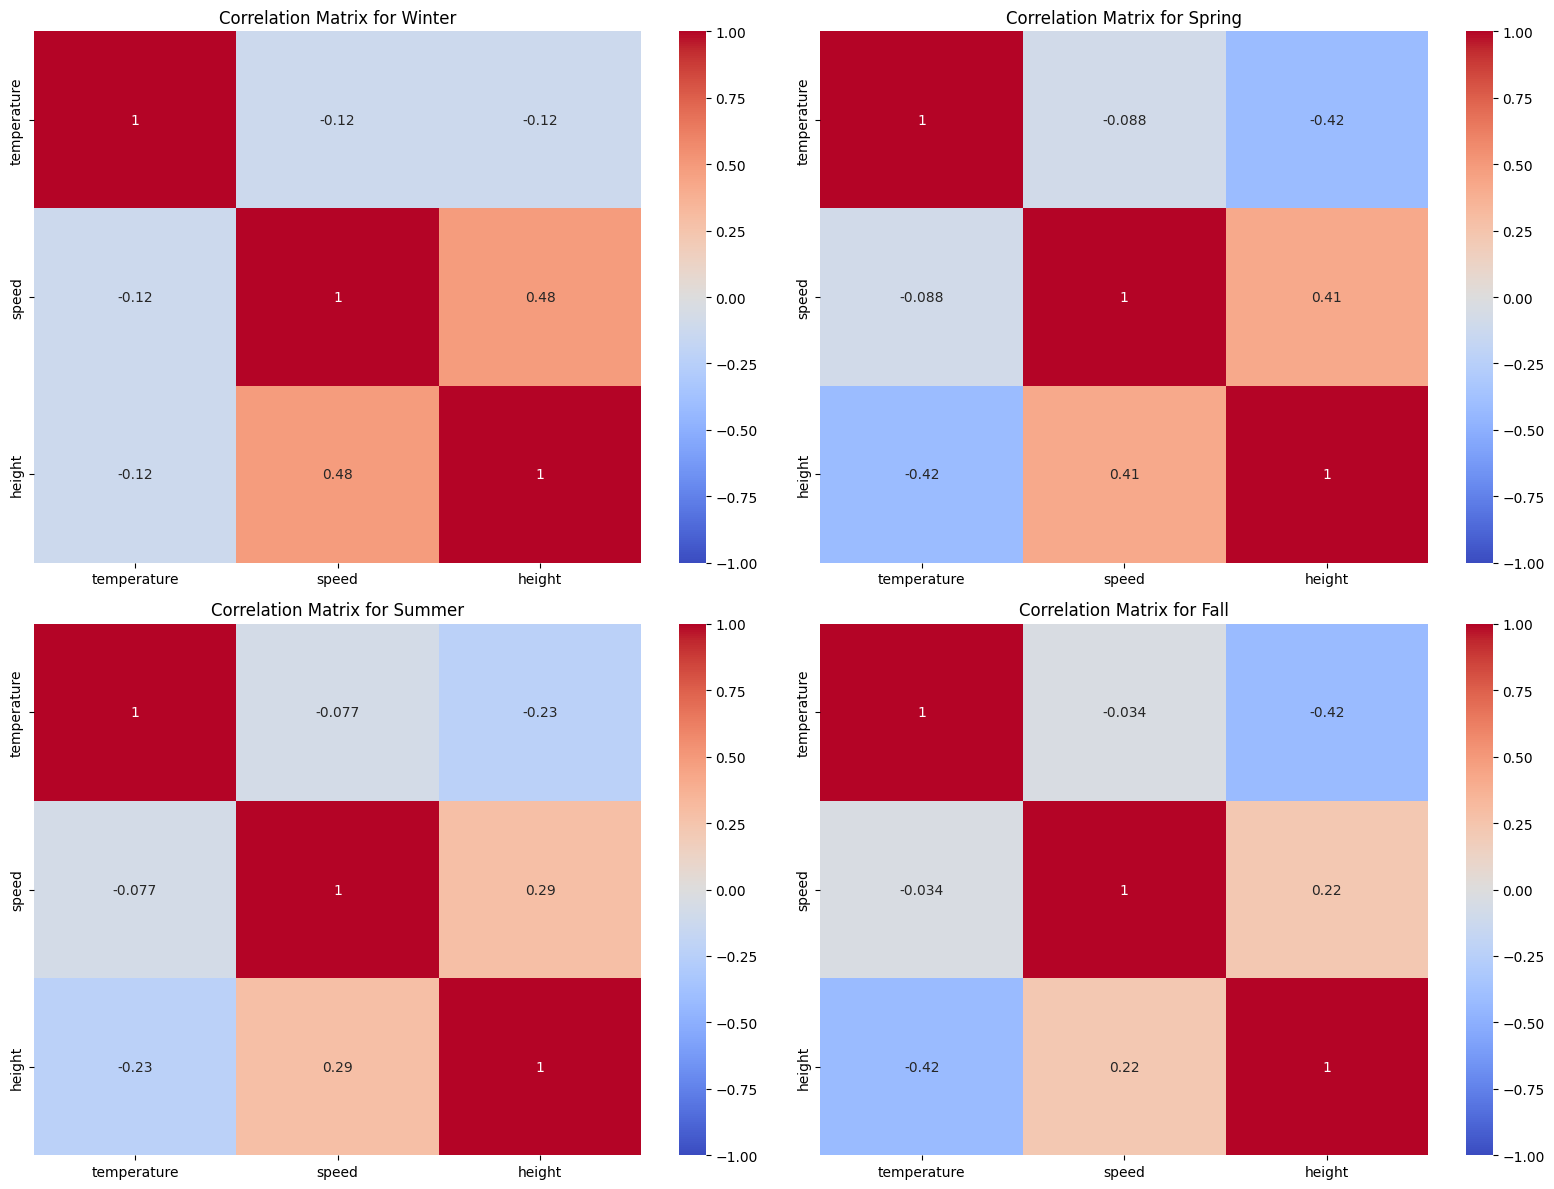

Correlation Matrix for Winter:
             temperature     speed    height
temperature     1.000000 -0.120974 -0.117655
speed          -0.120974  1.000000  0.484671
height         -0.117655  0.484671  1.000000

Correlation Matrix for Spring:
             temperature     speed    height
temperature     1.000000 -0.088309 -0.418286
speed          -0.088309  1.000000  0.414717
height         -0.418286  0.414717  1.000000

Correlation Matrix for Summer:
             temperature     speed    height
temperature     1.000000 -0.076677 -0.231601
speed          -0.076677  1.000000  0.287861
height         -0.231601  0.287861  1.000000

Correlation Matrix for Fall:
             temperature     speed    height
temperature     1.000000 -0.034024 -0.421883
speed          -0.034024  1.000000  0.219959
height         -0.421883  0.219959  1.000000



In [8]:
# Define function to assign season
def assign_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Assign season to each date
north_atlantic['season'] = north_atlantic.index.map(assign_season)

# Calculate correlation matrix for each season
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
correlation_matrices = {}

for season in seasons:
    seasonal_data = north_atlantic[north_atlantic['season'] == season]
    correlation_matrices[season] = seasonal_data[['temperature', 'speed', 'height']].corr()

# Plot heatmaps of correlation matrices for each season
plt.figure(figsize=(16, 12))

for i, season in enumerate(seasons, 1):
    plt.subplot(2, 2, i)
    sns.heatmap(correlation_matrices[season], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {season}')

plt.tight_layout()
plt.show()

# Interpret the results
for season in seasons:
    print(f'Correlation Matrix for {season}:')
    print(correlation_matrices[season])
    print()

## Conclusion

The analysis aimed to forecast sea surface temperature in the North Atlantic and explore the seasonal relationships between temperature, wind speed, and wave height. Using seasonal decomposition and an autoregressive model, we successfully forecasted future temperatures, with the forecast closely aligning with actual test data. Correlation analysis revealed that temperature consistently showed a negative correlation with wave height across all seasons, with the strongest negative correlation in Fall. Wind speed and wave height consistently had a positive correlation, highest in Winter. Temperature had a weak negative correlation with wind speed in all seasons.